# Get Normalized Throughputs from Pandeia

In [1]:
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Import pandeia and set paths

This is pretty hacky and there must be a better way to do this.

In [186]:
pandeia_code_path = '/grp/jwst/jwstetc/pandeia/engine'
sys.path.append(pandeia_code_path)  # required to access installed pandeia codebase

import pandeia, pandeia.engine, pandeia.engine.config

# Set default path to find the reference files
# THis must be done BEFORE importnig pandeia.engine.jwst
pandeia.engine.config.default_refdata('/grp/jwst/jwstetc/pandeia_data/')

import pandeia.engine.jwst
from pandeia.engine.instrument_factory import InstrumentFactory

## Infrastructure helper functions

First define some helpful functions to use below. 

In [207]:
def get_pce(inst, normalize=False):
    wr = inst.get_wave_range()
    wave = np.linspace(wr['wmin']*0.95, wr['wmax']*1.05, num=500)
    pce = inst.get_total_eff(wave)    
    if normalize:
        pce /= pce.max()
    return (wave,pce)


def annotate_pce_plot(title="", xlim=(0.5,5.5), legend=True):
    plt.title(title)
    plt.ylabel("Photon Conversion Efficiency")
    plt.xlabel('Wavelength [$\mu$m]')
    plt.ylim(0,1)
    plt.xlim(*xlim)
    if legend:
        plt.legend(loc='upper right')
        
def plotlabelcolorfilt(wave,pce,filtname, color='blue'):
    plt.fill_between(wave,0,pce, alpha=0.5, color=color)
    plt.plot(wave,pce, color=color, label=filtname.upper())
    plt.plot(wave,pce, color='black', alpha=0.5)
    # double print text to make it a bit darker since some of the rainbow colors are hard to read
    plt.text(wave.mean(), 0.75, filtname.upper(), alpha=1, color='black', rotation=45)
    plt.text(wave.mean(), 0.75, filtname.upper(), alpha=0.75, color=color, rotation=45)

def uppercase_si_name(name):
    # the SI name with case as typically used, and specifically as used with WebbPSF. 
    name = name.upper()
    if name=='NIRCAM': return 'NIRCam'
    elif name=='NIRSPEC': return 'NIRSpec'
    else: return name
    


In [208]:
def output_to_fits_table(wave,pce,inst, verbose=True, filtername=None):

    data = [wave*1e4,pce/pce.max()]  # convert wave to angstroms as expected by pysynphot

    (year, month, day, hour, minute, second, weekday, DOY, DST) =  time.gmtime()

    si_name = uppercase_si_name(inst.inst_name)
    if filtername is None:
        filtername = inst.instrument['filter']
    filtername = filtername.upper()

    t = Table(data, names=['WAVELENGTH', 'THROUGHPUT'])
    t['WAVELENGTH'].unit='angstrom'
    t.meta['WAVEUNIT']=('angstrom', 'Wavelength unit')
    t.meta['TELESCOP']=('JWST', 'James Webb Space Telescope')
    t.meta['INSTRUME']=(si_name, 'Name of instrument')
    t.meta['FILTER']=(filtername, 'Bandpass filter identifier')
    t.meta['SOURCE']=('JWST ETC / Pandeia / REDCAT', 'Derived from JWST ETC database')
    t.meta["SRC_DATE"] = ( "%4d-%02d-%02d" % (year, month, day), "Date of file generation from ETC")

    t.meta['NORMALIZ']=(True, 'Normalized to peak transmission=1')

    t.meta['HISTORY'] = ['Normalized relative spectral response file for WebbPSF', '',
                         'Based on information extracted from the ',
                         'JWST Exposure Time Calculator (ETC) system',
                         '(Pandeia software database, using reference files',
                         'managed by ReDCaT, the Reference Data for ',
                         'Calibration and Tools group at STScI)', '',
                         'File created by: webbpsf/dev_tools/',
                         '  Normalized Throughputs from Pandeia.ipynb',
                         '']

    if not os.path.isdir('outputs'):
        os.mkdir('outputs')
    
    if not os.path.isdir(os.path.join('outputs',si_name)):
        os.mkdir(os.path.join('outputs',si_name))
    
    outname = os.path.join('outputs',si_name,"{}_throughput.fits".format(filtername))
    t.write(outname, overwrite=True)
    if verbose:
        print("==>> "+outname)
    return outname



## Obtain & display Photon Conversion Efficiency for a single filter

NIRISS used as simple imager test case since NIRCam has the SW/LW complication. 

==>> outputs/NIRISS/F090W_throughput.fits


'outputs/NIRISS/F090W_throughput.fits'

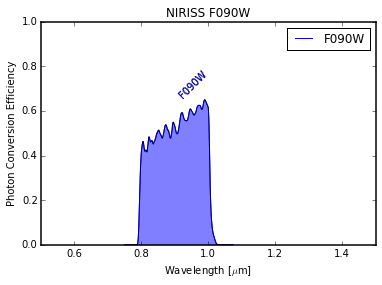

In [209]:
inst = pandeia.engine.jwst.NIRISS(mode='imaging')
wave,pce=get_pce(inst)

plotlabelcolorfilt(wave,pce, inst.instrument['filter'])

annotate_pce_plot(title=("{} {}".format(inst.instrument['instrument'], 
                                        inst.instrument['filter'])).upper(), 
                  xlim=(0.5, 1.5))
output_to_fits_table(wave,pce,inst)

## Iterate over all filters for an instrument

### Instruments that do work - NIRISS, MIRI, NIRCam 

==>> outputs/NIRISS/F090W_throughput.fits
==>> outputs/NIRISS/F115W_throughput.fits
==>> outputs/NIRISS/F140M_throughput.fits
==>> outputs/NIRISS/F150W_throughput.fits
==>> outputs/NIRISS/F158M_throughput.fits
==>> outputs/NIRISS/F200W_throughput.fits
==>> outputs/NIRISS/F277W_throughput.fits
==>> outputs/NIRISS/F356W_throughput.fits
==>> outputs/NIRISS/F380M_throughput.fits
==>> outputs/NIRISS/F430M_throughput.fits
==>> outputs/NIRISS/F444W_throughput.fits
==>> outputs/NIRISS/F480M_throughput.fits


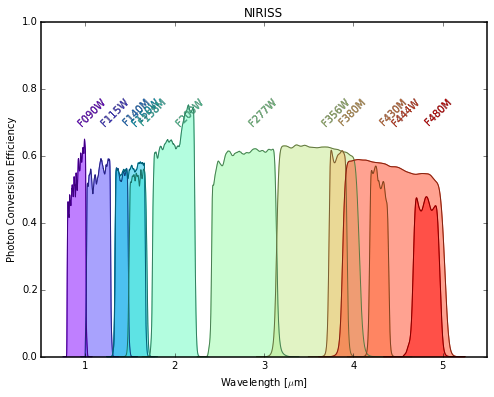

In [210]:
inst_defaults = pandeia.engine.jwst.NIRISS(mode='imaging')
config = inst_defaults.as_dict()  # get default config
colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(inst_defaults.filters))))


plt.figure(figsize=(8,6))
for filtname in inst_defaults.filters:
    
    config['instrument']['filter']=filtname
    inst = InstrumentFactory(config=config)

    wave,pce=get_pce(inst)
    plotlabelcolorfilt(wave,pce,filtname, color=next(colorseq))
    output_to_fits_table(wave,pce,inst)

annotate_pce_plot(title=inst.inst_name.upper(), legend=False)

==>> outputs/MIRI/F1065C_throughput.fits
==>> outputs/MIRI/F1140C_throughput.fits
==>> outputs/MIRI/F1550C_throughput.fits
==>> outputs/MIRI/F2300C_throughput.fits
==>> outputs/MIRI/F560W_throughput.fits
==>> outputs/MIRI/F770W_throughput.fits
==>> outputs/MIRI/F1000W_throughput.fits
==>> outputs/MIRI/F1130W_throughput.fits
==>> outputs/MIRI/F1280W_throughput.fits
==>> outputs/MIRI/F1500W_throughput.fits
==>> outputs/MIRI/F1800W_throughput.fits
==>> outputs/MIRI/F2100W_throughput.fits
==>> outputs/MIRI/F2550W_throughput.fits


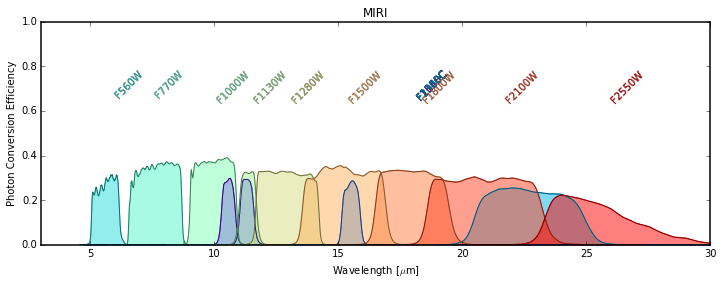

In [211]:
inst_defaults = pandeia.engine.jwst.MIRI(mode='imaging')
config = inst_defaults.as_dict()  # get default config

plt.figure(figsize=(12,4))
colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(inst_defaults.filters))))


for filtname in inst_defaults.filters:

    config['instrument']['filter']=filtname
    inst = pandeia.engine.jwst.MIRI(mode='imaging', config=config)

    wave,pce=get_pce(inst)
    plotlabelcolorfilt(wave,pce,filtname, color=next(colorseq))
    output_to_fits_table(wave,pce,inst)

annotate_pce_plot(title=uppercase_si_name(inst.inst_name), xlim=(3,30), legend=False)

For NIRCam - note the no-longer-present F225N and F418N should be ignored. Will be removed in next Pandeia update. 
Missing the W2 filters also.

==>> outputs/NIRCam/F070W_throughput.fits
==>> outputs/NIRCam/F090W_throughput.fits
==>> outputs/NIRCam/F115W_throughput.fits
==>> outputs/NIRCam/F150W_throughput.fits
==>> outputs/NIRCam/F200W_throughput.fits
==>> outputs/NIRCam/F277W_throughput.fits
==>> outputs/NIRCam/F322W2_throughput.fits
==>> outputs/NIRCam/F356W_throughput.fits
==>> outputs/NIRCam/F444W_throughput.fits
==>> outputs/NIRCam/F140M_throughput.fits
==>> outputs/NIRCam/F162M_throughput.fits
==>> outputs/NIRCam/F182M_throughput.fits
==>> outputs/NIRCam/F210M_throughput.fits
==>> outputs/NIRCam/F210M_throughput.fits
==>> outputs/NIRCam/F250M_throughput.fits
==>> outputs/NIRCam/F300M_throughput.fits
==>> outputs/NIRCam/F335M_throughput.fits
==>> outputs/NIRCam/F360M_throughput.fits
==>> outputs/NIRCam/F410M_throughput.fits
==>> outputs/NIRCam/F430M_throughput.fits
==>> outputs/NIRCam/F460M_throughput.fits
==>> outputs/NIRCam/F480M_throughput.fits
==>> outputs/NIRCam/F164N_throughput.fits
==>> outputs/NIRCam/F187N_through

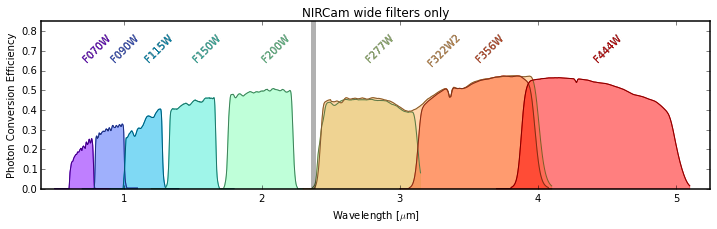

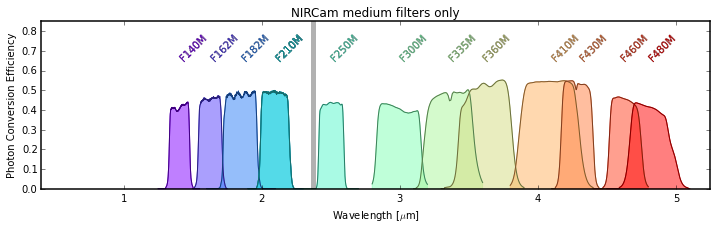

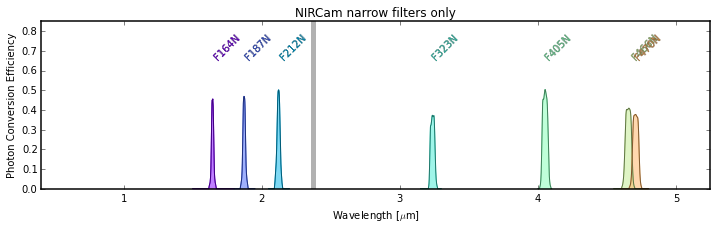

In [212]:
inst_defaults = pandeia.engine.jwst.NIRCam(mode='sw_imaging')
config_sw = inst_defaults.as_dict()  # get default config
inst_defaults = pandeia.engine.jwst.NIRCam(mode='lw_imaging')
config_lw = inst_defaults.as_dict()  # get default config



for width in ['wide','medium','narrow']:

    plt.figure(figsize=(12,3))
    nfilters = len([filt for filt in inst.filters if width[0] in filt])
    colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,nfilters)))
    
    for filtname in inst_defaults.filters:

        if width[0] not in filtname: continue
        if filtname=='f225n' or filtname=='f418n': continue # no longer present in NIRCam

        if int(filtname[1:3]) < 25:
            mode = 'sw_imaging' 
            config = config_sw
        else:
            mode = 'lw_imaging'
            config = config_lw
        config['instrument']['filter']=filtname
        
        if filtname=='f322w': filtname='f322w2' # work around limitation in current config setup
          
        inst = pandeia.engine.jwst.NIRCam(mode=mode, config=config)

        wr = inst.get_wave_range()
        wave = np.linspace(wr['wmin'], wr['wmax'], num=500)
        pce = inst.get_total_eff(wave)

        plotlabelcolorfilt(wave,pce,filtname, color=next(colorseq))
        output_to_fits_table(wave,pce,inst, filtername=filtname)

    annotate_pce_plot(title=uppercase_si_name(inst.inst_name)+" {} filters only".format(width), 
                      xlim=(0.4, 5.25), legend=False)
    plt.ylim(0,0.85)  #match NIRCam pocket guide PDF
    plt.axvline(2.37, ls="-", color='black', alpha=0.3, linewidth=5) 
 

### Instruments that don't work yet - NIRSpec and FGS

Tim P says in Feb 2016: 

"nirspec imaging hasn’t been implemented yet.  there are stubs for it in the configuration file, but not all of the necessary configuration data is there. "

In [105]:
inst_defaults = pandeia.engine.jwst.NIRSpec(mode='imaging')
config = inst_defaults.as_dict()  # get default config

plt.figure(figsize=(8,6))
colorseq=iter(matplotlib.cm.rainbow(np.linspace(0,1,len(inst_defaults.filters))))


for filtname in inst_defaults.filters:

    config['instrument']['filter']=filtname
    inst = pandeia.engine.jwst.NIRSpec(mode='imaging', config=config)

    wave,pce=get_pce(inst)
    color=next(colorseq)
    plt.fill_between(wave,0, pce, color=color, alpha=0.5)
    plt.plot(wave,pce,color=color, label=filtname.upper())


annotate_pce_plot(title=inst.inst_name.upper(), xlim=(3,30))

KeyError: u'full'

In [106]:
# FGS is not in Pandeia - get the spectral response from someone on FGS team directly. 

## Convert into webbpsf-compatible FITS tables

In [143]:
from astropy.table import Table
import time
import webbpsf
_log = webbpsf.webbpsf_core._log
import pysynphot

In [185]:
inst = pandeia.engine.jwst.NIRCam(mode='sw_imaging')


outname = output_to_fits_table(wave,pce,inst)

==>> outputs/NIRCam/F070W_throughput.fits


In [213]:
# Check the header looks as we desire it to:
f = fits.open(outname)
f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                  500 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'WAVELENGTH'                                                          
TFORM1  = 'D       '                                                            
TTYPE2  = 'THROUGHPUT'                                                          
TFORM2  = 'D       '                                                            
WAVEUNIT= 'angstrom'        

In [214]:
def read_filter_data_like_webbpsf_does(filename, filtername):
    """Copied from webbpsf_core SpaceTelescopeInstrument._getSynphotBandpass() """
    # The existing FITS files all have wavelength in ANGSTROMS since that is
    # the pysynphot convention...
    
    #filterfits = fits.open(filter_info.filename)
    filterfits=fits.open(filename)
    
    waveunit = filterfits[1].header.get('WAVEUNIT')
    if waveunit is None:
        _log.warn('The supplied file, {}, does not have a WAVEUNIT keyword. Assuming it '
                  'is Angstroms.'.format(filter_info.filename))
        waveunit = 'angstrom'

    filterdata = filterfits[1].data
    try:
        band = pysynphot.spectrum.ArraySpectralElement(
            throughput=filterdata.THROUGHPUT, wave=filterdata.WAVELENGTH,
            waveunits=waveunit, name=filtername
        )
    except AttributeError:
        raise ValueError("The supplied file, %s, does not appear to be a FITS table "
                         "with WAVELENGTH and THROUGHPUT columns." % filter_info.filename)

    return band


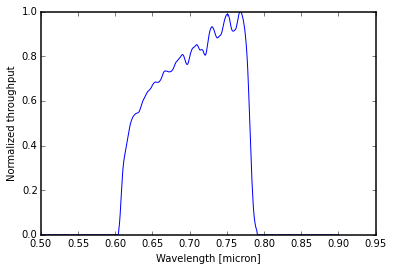

In [216]:
band = read_filter_data_like_webbpsf_does(outname, 'test')
import poppy.utils
from webbpsf.tkgui import synplot
synplot(band)
plt.ylabel("Normalized throughput")